# Data Cleaning using R (Cold Spray Log Reader)

## Introduction

Cold spray is a coating deposition process in which powdered material is accelerated to supersonic speeds, as high as Mach 3. The accelerated powder is deposited onto a similar or dissimilar material surface. The powders reach high velocity using a high-pressure, electrically heated carrier gas, like nitrogen or helium.

<img src="cold-spray-process.jpg">

Every time a spray is done, machine generates a log. In the event, where the coating quality is not good the logs are inspected to see what caused the problem. However, the log generated by the machine is extremely messy and requires lot of cleaning before any interpretation can be made from it. In this notebook, I cleaned the log and plotted it against time to compare the actual values with the set point values.

<img src="coldsprayam.png">

## Loading the required libraries

In [26]:
library(DT)
library(dplyr)
library(lubridate)
library(ggpubr)
library(ggplot2)
library(scales)
library(tidyr)
library(formattable)
library(GGally)
library(vtable)

Loading required package: kableExtra

Warning message:
"package 'kableExtra' was built under R version 3.6.3"

Attaching package: 'kableExtra'


The following object is masked from 'package:dplyr':

    group_rows




## Loading the log csv file

In [2]:
df = read.csv("Data Log 10_20210410_165642_HMI.csv", header = T)

#Viewing random 10 values from the imported csv file
df[sample(nrow(df), 10), ]

,VarName,TimeString,VarValue,Validity,Time_ms
7417,PT3_Display,4/10/2021 11:48:23 AM,0.2170139,1,44296491932
3203,MFC1 Real Display,4/10/2021 11:38:03 AM,20,1,44296484755
10000,Selected System Pressure in PSI From HMI,4/10/2021 11:54:43 AM,400,1,44296496329
6664,Gen III External interlocks Status Reset,4/10/2021 11:46:23 AM,24320,1,44296490542
9030,R6/EBV1 Helium Ball Valve Open,4/10/2021 11:52:13 AM,0,1,44296494593
1906,PT1_Display,4/10/2021 11:33:26 AM,1.519097,1,44296481549
8164,Selected System Pressure in PSI From HMI,4/10/2021 11:50:13 AM,950,1,44296493204
7903,Enable Powder Feeder For An Automatic Cycle,4/10/2021 11:49:33 AM,-1,1,44296492741
8367,PT2_Display,4/10/2021 11:50:43 AM,1087.674,1,44296493551
7792,Alarms Group 2 Disable Status,4/10/2021 11:49:13 AM,32766,1,44296492509


## Cleaning the file

In [11]:
a1 = data.frame(    #Importing the time in correct format
                     Timestamp = as.POSIXct(strptime(df[df$VarName=="PT2_Display",]$TimeString, format="%m/%d/%Y %H:%M:%S %p")),
                    #Filtering PT2 values and so on...
                     PT2 = as.numeric(as.character(df[df$VarName=="PT2_Display",]$VarValue)),
                     MFM2 = as.numeric(as.character(df[df$VarName=="MFC2 Real Display",]$VarValue)),
                     MFM3 = as.numeric(as.character(df[df$VarName=="MFC3 Real Display",]$VarValue)),
                     `PF_Motor_RPM` = as.numeric(as.character(df[df$VarName=="PF Motor RPM",]$VarValue)),
                     PF_Flow_Setpoint = as.numeric(as.character(df[df$VarName=="Powder Feeder Flow Rate Setpoint",]$VarValue)),
                     `N2_System_Pressure` = as.numeric(as.character(df[df$VarName=="PT4_Display",]$VarValue )),
                     System_feedback_pressure = as.numeric(as.character(df[df$VarName=="EPR1 Manual Bar Input_Real",]$VarValue)),
                     Powder_Feeder_Pressure = as.numeric(as.character(df[df$VarName=="PT8_Display",]$VarValue)),
                    PF_rpm_setpoint = as.numeric(as.character(df[df$VarName=="PF Motor Setpoint from HMI as Real",]$VarValue)),
                    System_pressure_setpoint = as.numeric(as.character(df[df$VarName=="Selected System Pressure in PSI From HMI",]$VarValue)),
                    Heater_1 =  as.numeric(as.character(as.character(df[df$VarName=="TC10_Temperature",]$VarValue))),
                    Heater_2 =  as.numeric(as.character(df[df$VarName=="TC11_Temperature",]$VarValue)),
                    Heater_3 = as.numeric(as.character(df[df$VarName=="TC12_Temperature",]$VarValue)),
                    Applicator_temperature = as.numeric(as.character(df[df$VarName=="TC13_Temperature",]$VarValue)),
                    Applicator_temperature_setpoint = as.numeric(as.character(df[df$VarName=="Selected Heater Setpoint (Predicted)",]$VarValue))
    )

In [12]:
#Viewing random 6 values from the a1 dataframe 
a1[sample(nrow(a1), 6), ]

,Timestamp,PT2,MFM2,MFM3,PF_Motor_RPM,PF_Flow_Setpoint,N2_System_Pressure,System_feedback_pressure,Powder_Feeder_Pressure,PF_rpm_setpoint,System_pressure_setpoint,Heater_1,Heater_2,Heater_3,Applicator_temperature,Applicator_temperature_setpoint
8,2021-04-10 11:29:56,1191.298,7,0,0,150,1.0127310,0.00000,7.957176,5,400,210.5,309.0,447.7,146.2,385.00
148,2021-04-10 11:54:43,1133.030,14,0,0,150,16.7462400,0.50000,53.240740,5,400,324.2,416.1,550.0,370.4,395.50
20,2021-04-10 11:31:56,1195.747,8,0,0,150,0.9765625,0.00000,4.159433,5,400,199.8,300.1,436.9,127.4,367.50
152,2021-04-10 11:55:23,1134.657,8,0,0,150,1.3020830,0.50000,16.276040,5,400,346.2,436.9,572.8,338.4,395.50
138,2021-04-10 11:53:03,1080.295,1382,150,5,150,954.9697000,66.39431,936.270300,5,950,423.5,515.7,651.4,395.8,423.75
14,2021-04-10 11:30:56,1193.685,8,0,0,150,1.0127310,0.00000,5.750868,5,400,204.4,305.0,441.3,135.8,367.50


## Summary Statistics

In [29]:
st(a1, out='return')

Variable,N,Mean,Std. Dev.,Min,Pctl. 25,Pctl. 75,Max
PT2,158,1126.117,43.594,1077.148,1096.002,1188.558,1205.404
MFM2,158,911.791,665.777,7,8,1391.75,1739
MFM3,158,88.57,73.061,-1,0,149,154
PF_Motor_RPM,158,2.468,2.507,0,0,5,5.056
PF_Flow_Setpoint,158,150,0,150,150,150,150
N2_System_Pressure,158,622.744,452.525,0.904,1.058,953.957,954.97
System_feedback_pressure,158,43.259,31.59,0,0.5,66.394,66.394
Powder_Feeder_Pressure,158,610.013,437.753,1.013,11.004,935.475,953.27
PF_rpm_setpoint,158,5,0,5,5,5,5
System_pressure_setpoint,158,796.835,247.322,400,400,950,950


Parameters with 0 standard deviation are basically those values which the user wants. They are not the actual values. They are the set point values, therefore the standard deviation is 0.

## Defining Colors for different variables

In [14]:
colors1 <- c("Powder Feeder \nFlow Setpoint" = "#1952e0", "MFM3" = "#2f3136")
colors2 <- c("Nitrogen Inlet Pressure" = "#cf462d", 
            "Nitrogen System Pressure" = "#7fd91e",
            "System Pressure Feedback" = "#11d2d9", 
            "Powder Feeder Pressure" = "#0918eb",
            "System Pressure Setpoint" = "#1952e0")
colors3 <- c("Heater 1" = "#cf462d", 
             "Heater 2" = "#7fd91e",
             "Heater 3" = "#11d2d9", 
             "Applicator Temperature" = "#0918eb",
             "Applicator Temperature Setpoint" = "#1952e0")

colors4 = c("PF Motor RPM" = "#cf462d", 
            "PF Set Point" = "#1952e0")

## Powder Feeder Trend

In [15]:
PFT1 = 
ggplot(a1, aes(x=Timestamp))+
  geom_point(aes(y=PF_Motor_RPM,color="PF Motor RPM"), size=1.3)+
  geom_line( aes(y=PF_Motor_RPM,color = "PF Motor RPM"),size=1)+
  geom_point(aes(y=PF_rpm_setpoint,color="PF Set Point"), size=1.3)+
  geom_line( aes(y=PF_rpm_setpoint,color = "PF Set Point"),size=1)+
  ylab("Powder Feed Rate (RPM)")+
  ggtitle("Powder Feeder Trend")+
  scale_x_datetime(breaks = date_breaks("160 sec"), 
                   labels = date_format("%H:%M",tz = "America/Chicago")) + 
  theme(axis.text.x = element_text(vjust = 0.75,angle = 30))+
  scale_y_continuous(breaks = seq(0,10,2))+
  expand_limits(y=c(0,10))+xlab("Timestamp (hours:minutes)") + 
  theme(axis.title = element_text(size = 12, face = "bold"), 
        axis.text.x = element_text(size = 11), 
        plot.title = element_text(size = 13, face = "bold", hjust = 0.5),
        axis.text.y = element_text(size = 11))+
  scale_color_manual(values = colors4)

## Powder Feeder Flow Trend

In [16]:
PFFT1 = 
  ### Powder Feeder Flow Trend

ggplot(a1, aes(x=Timestamp))+
  geom_point(aes(y=MFM3,color="MFM3"), size=1.3)+
  geom_line( aes(y=MFM3,color = "MFM3"),size=1)+
  geom_line(aes(y = PF_Flow_Setpoint, color = "Powder Feeder \nFlow Setpoint"),size=1)+ylab("Flow Rate (SLM)")+
  ggtitle("Powder Feeder Flow Trend")+
  geom_point(aes(y = PF_Flow_Setpoint, color = "Powder Feeder \nFlow Setpoint"), size=1.3)+
  scale_x_datetime(breaks = date_breaks("160 sec"), labels = date_format("%H:%M",tz = "America/Chicago")) + 
  theme(axis.text.x = element_text(vjust = 0.75,angle = 30))+scale_y_continuous(breaks = seq(0,200,30))+
  expand_limits(y=c(0,180))+xlab("Timestamp (hours:minutes)") + theme(axis.title = element_text(size = 12, 
    face = "bold"), axis.text.x = element_text(size = 11), plot.title = element_text(size = 13, face = "bold", hjust = 0.5),
    axis.text.y = element_text(size = 11))+scale_color_manual(values = colors1) 

## Pressure Trend

In [18]:
PT1 = 
ggplot(a1, aes(x=Timestamp))+
  geom_point(aes(y=PT2,color="Nitrogen Inlet Pressure"), size=1.3)+
  geom_line( aes(y=PT2,color = "Nitrogen Inlet Pressure"),size=1)+
  geom_point(aes(y=N2_System_Pressure,color="Nitrogen System Pressure"), size=1.3)+
  geom_line( aes(y=N2_System_Pressure,color = "Nitrogen System Pressure"),size=1)+
  geom_point(aes(y=System_feedback_pressure,color="System Pressure Feedback"), size=1.3)+
  geom_line( aes(y=System_feedback_pressure,color = "System Pressure Feedback"),size=1)+
  geom_point(aes(y=Powder_Feeder_Pressure,color="Powder Feeder Pressure"), size=1.3)+
  geom_line( aes(y=Powder_Feeder_Pressure,color = "Powder Feeder Pressure"),size=1)+
  geom_point(aes(y=System_pressure_setpoint,color="System Pressure Setpoint"), size=1.3)+
  geom_line( aes(y=System_pressure_setpoint,color = "System Pressure Setpoint"),size=1)+
  ylab("Pressure (PSI)")+
  ggtitle("Pressure Trend")+
  scale_x_datetime(breaks = date_breaks("160 sec"), 
                   labels = date_format("%H:%M",tz = "America/Chicago")) + 
  theme(axis.text.x = element_text(vjust = 0.75,angle = 30))+
  scale_y_continuous(breaks = seq(0,1450,150))+
  expand_limits(y=c(0,1400))+xlab("Timestamp (hours:minutes)") + 
  theme(axis.title = element_text(size = 12, face = "bold"), 
        axis.text.x = element_text(size = 11), 
        plot.title = element_text(size = 13, face = "bold", hjust = 0.5),
        axis.text.y = element_text(size = 11))+
  scale_color_manual(values = colors2)

## Heater Trend

In [20]:
HT1 = 
ggplot(a1, aes(x=Timestamp))+
  geom_point(aes(y=Heater_1,color="Heater 1"), size=1.3)+
  geom_line( aes(y=Heater_1,color = "Heater 1"),size=1)+
  geom_point(aes(y=Heater_2,color="Heater 2"), size=1.3)+
  geom_line( aes(y=Heater_2,color = "Heater 2"),size=1)+
  geom_point(aes(y=Heater_3,color="Heater 3"), size=1.3)+
  geom_line( aes(y=Heater_3,color = "Heater 3"),size=1)+
  geom_point(aes(y=Applicator_temperature,color="Applicator Temperature"), size=1.5)+
  geom_line( aes(y=Applicator_temperature,color = "Applicator Temperature"),size=1)+
  geom_point(aes(y=Applicator_temperature_setpoint,color="Applicator Temperature Setpoint"), size=1.5)+
  geom_line( aes(y=Applicator_temperature_setpoint,color = "Applicator Temperature Setpoint"),size=1)+
  ylab("Temperature (Deg C)")+
  ggtitle("Heater Trend")+
  scale_x_datetime(breaks = date_breaks("160 sec"), 
                   labels = date_format("%H:%M",tz = "America/Chicago")) + 
  theme(axis.text.x = element_text(vjust = 0.75,angle = 30))+
  scale_y_continuous(breaks = seq(0,800,125))+
  expand_limits(y=c(0,800))+xlab("Timestamp (hours:minutes)") + 
  theme(axis.title = element_text(size = 12, face = "bold"), 
        axis.text.x = element_text(size = 11), 
        plot.title = element_text(size = 13, face = "bold", hjust = 0.5),
        axis.text.y = element_text(size = 11))+
  scale_color_manual(values = colors3)

In [21]:
## Plotting

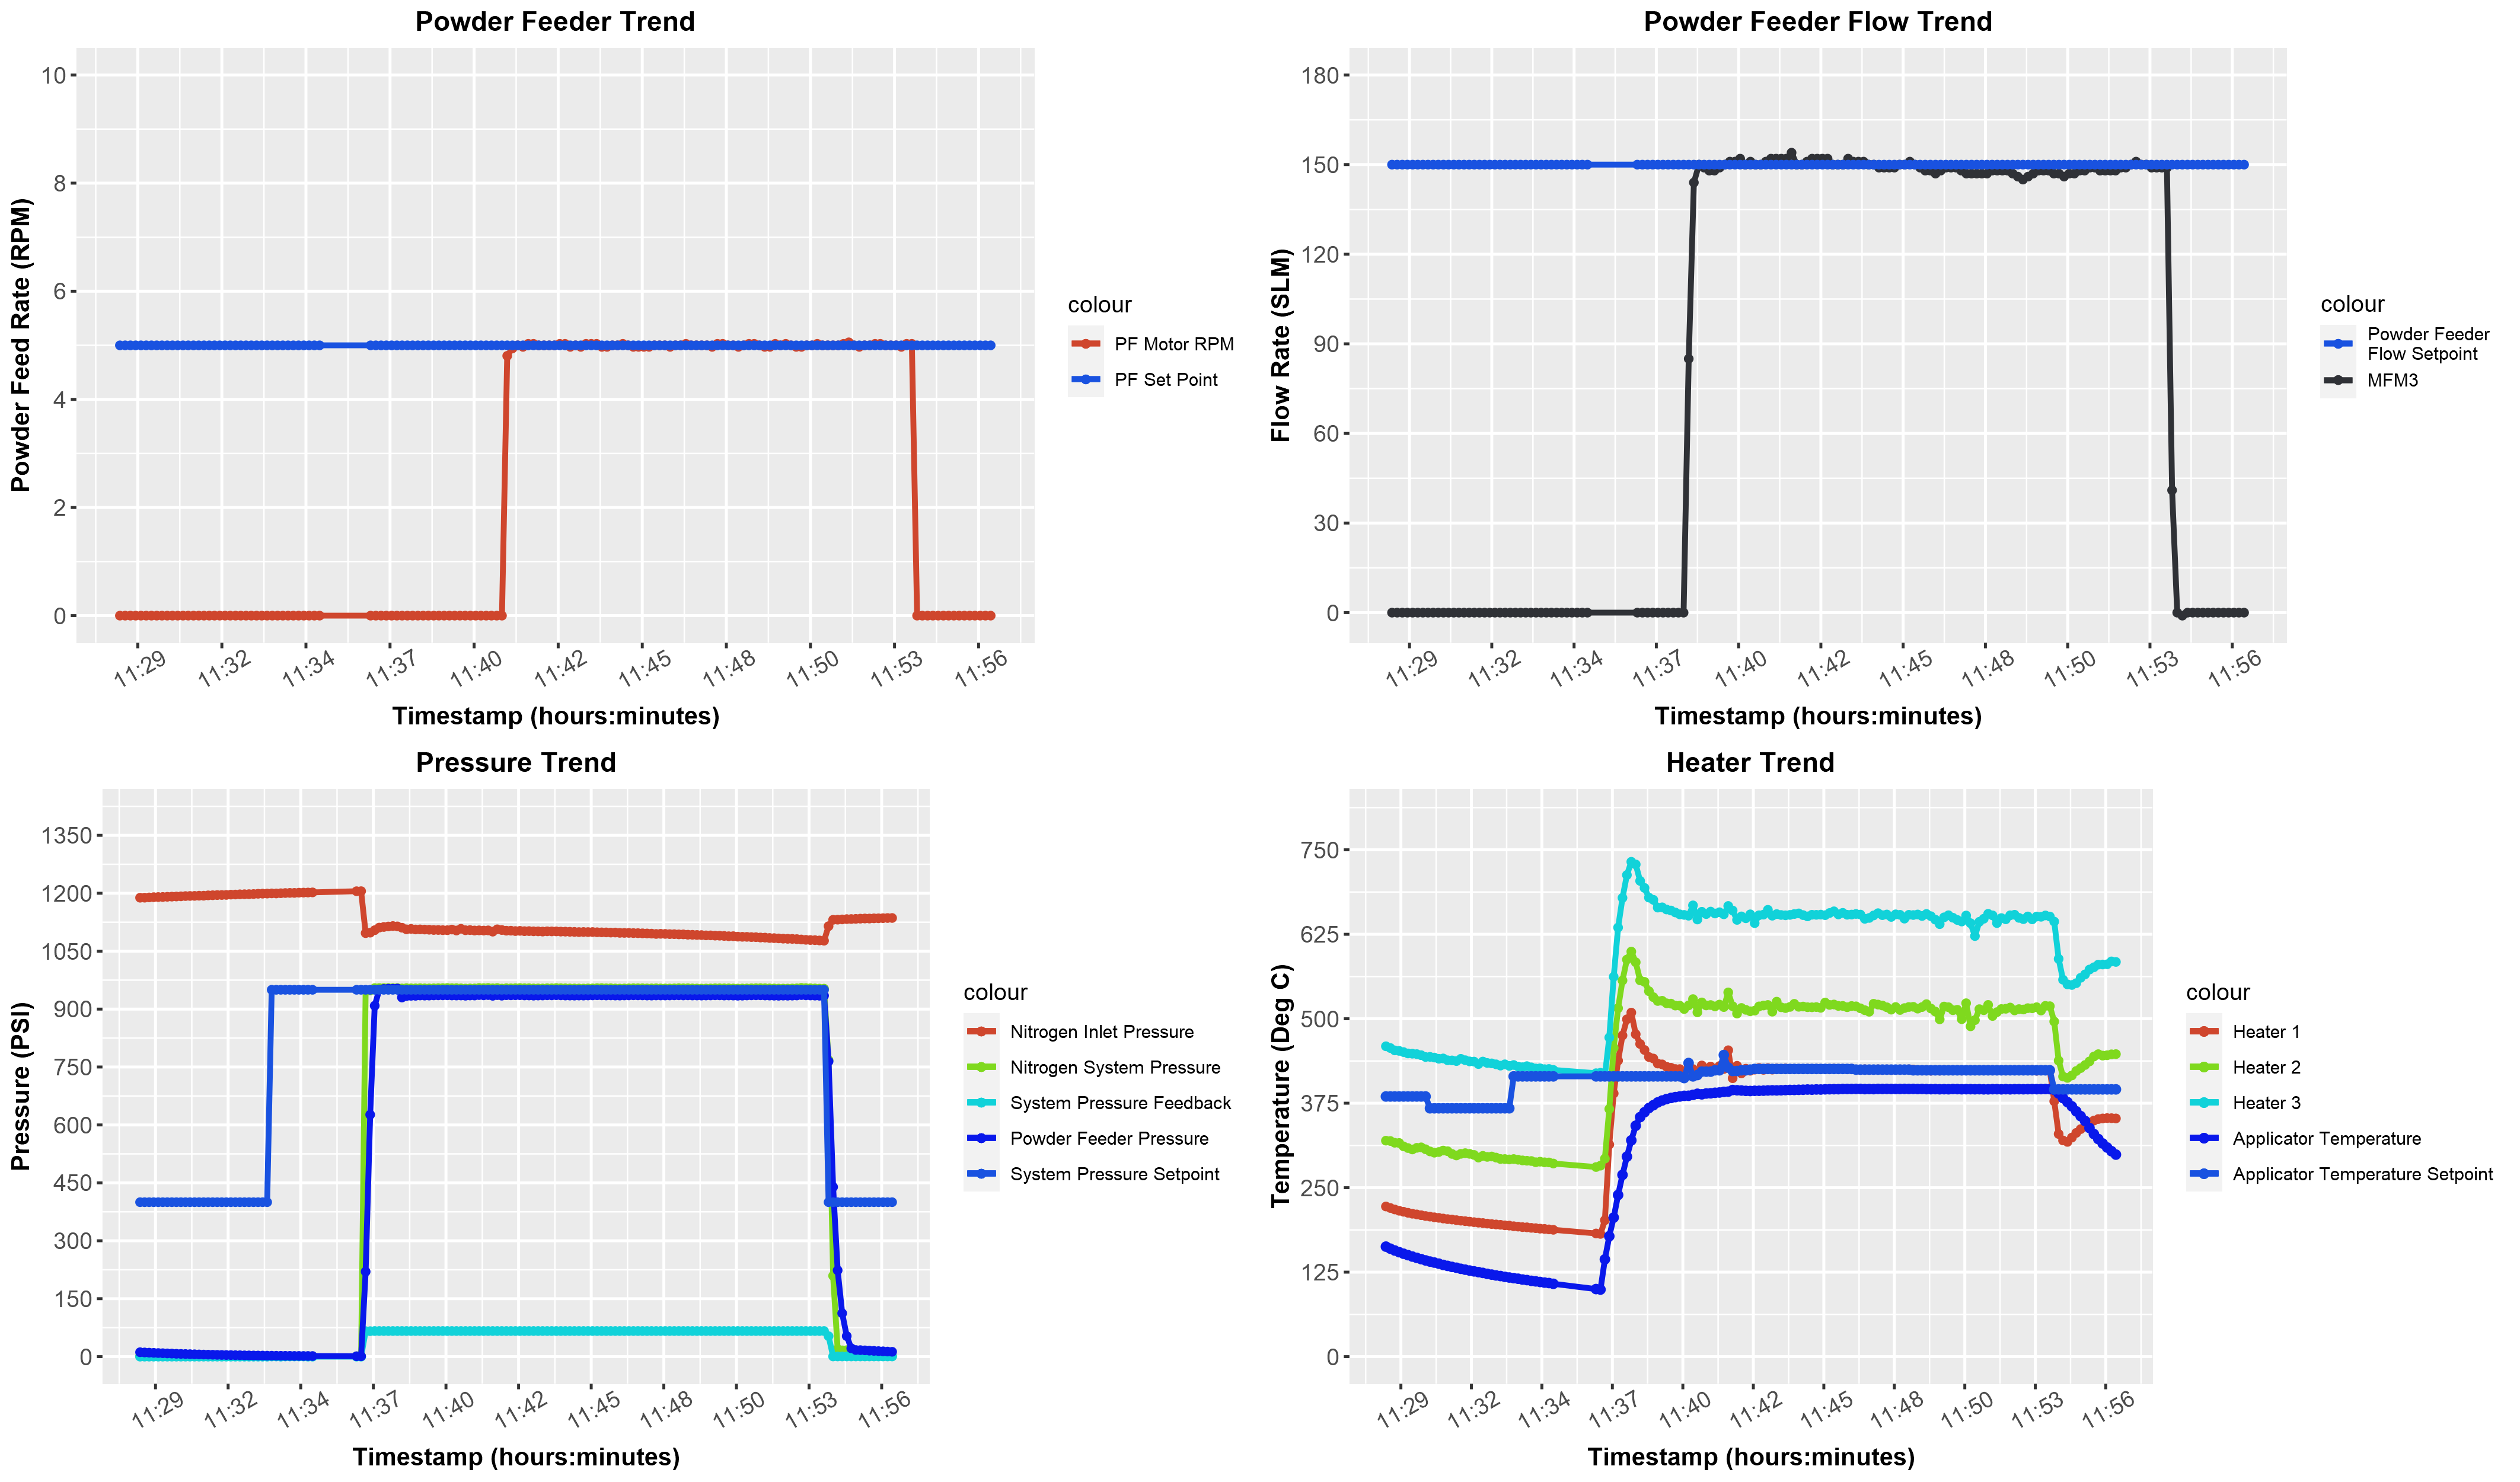

In [24]:
options(repr.plot.width=17, repr.plot.height=10,repr.plot.res = 250) #Defining the picture size and resolution
ggarrange(PFT1,PFFT1,PT1,HT1, ncol=2, nrow=2)

In the above plots, we compare the actual values vs the setpoint values at the given time. Ideally, we would would want the actual values to overlap the setpoint values for the machine to be 100% efficient. 

**-- Deepansh Arora**